In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

In [ ]:
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from variables import target_col

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
df = pd.read_csv('../Data/dataset_cleaned.csv')

/tmp/ipykernel_982580/1920096548.py:1: DtypeWarning: Columns (11,21,22,23,24,34,35,36,37,38,43,47,48,52,53,54,60,71,75,120,121,123,124,126,135,137,138,139,140,141,142,143,151,156,157,158,160,161,162,209,215,217,218,220,232,250,251,253,502,508,510,512,514,518,522,524,526,528) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/dataset_cleaned.csv')


In [6]:
# import labels
labels_df = pd.read_excel('../Data/short_codebook_SK1_pgeld_with_labels.xlsx', index_col='Variable Name')
labels_df_2 = pd.read_excel('../Data/short_codebook_SK1_pgeld_with_labels_oct2022.xlsx', index_col='Variable Name')
labels_df = pd.concat([labels_df, labels_df_2])[['Variable Label']]
#print(list(labels_df.loc[['sk1_id', 'sk1_fam'], 'Variable Label']))
labels_df.dropna(inplace=True)
labels_df['Variable Label'] = labels_df['Variable Label'].apply(lambda s: s.replace(' (NewVar)', ''))

In [7]:
# sodium-creatinine and potassium-creatinine ratios
df['un_na_k'] = df['una_un_mmol'] / df['uk_un_mmol']
df['un_na_crt'] = 1e3 * df['una_un_mmol'] / df['ucrt_un_umol']

labels_df.loc['un_na_k'] = 'Sodium-potassium excretion ratio'
labels_df.loc['un_na_crt'] = 'Sodium-creatinine excretion ratio'

# 10) Machine Learning models

This was just me playing a bit around to see whether we can get much better than the MLR models...

In [8]:
# columns assumed to correlate
all_cols = [
    'una_un', 'una_un_mmol', 'una_un_mmolh',
    'un_min', 'un_ml',
    'sex', 'age',
    'uk_un', 'uk_un_mmol', 'uk_un_mmolh', 'un_na_k', 'ucrt_un', 'ucrt_un_umol', 'ucrt_un_umolh', 'un_na_crt',
    'bmi',
    'sbp1_5', 'dbp1_5',
    'hypertension_combined', 'diabetes_combined',
    't_now', 't_ctf', 't_ct', # tobacco
    'd_diet', 'f_fruit', 'f_veg', 'f_meat_24n', 'f_fish', # diet: NOT USED
    'waist_hip', 'waistc1', # waist-to-hip
    'cho', 'ldl', 'ldlhdl', 'tg', # blood lipid values
    'e_now', 'e_p_past', 'unit_alc_week', # alcohol: ONLY UNITS USED
    'p_act1', 'p_act2', 'p_act3', 'p_act4', 'phys_activity_22fN', 'phys_activity_22fD', 'phys_activity_t', 'a_grad', # physical activity: ONLY A_GRAD USED
    'sleep_t', 'sleep_22fN', 'sleep_22fD', 'sleep_duration',# [follow-up] # sleep: NOT USED
    'sc_now', 'educat_code', 'edu_3cat', # education: ONLY EDU_3CAT USED
    'origin_final', # [follow-up] # origin: NOT USED
    'orig_regio', # [follow-up]: NOT USED
    'p_h_income', # [follow-up] # income: NOT USED
    'inc_hh', # [follow-up]: NOT USED
    'fin_diff', # [follow-up]: NOT USED
]

In [9]:
# selected columns from previous models with not too many missings
sel_cols = ['una_un', 'una_un_mmol', 'una_un_mmolh',
          'un_min', 'un_ml',
          'sex', 'age',
          't_now', 't_ctf', 't_ct',
          'uk_un', 'uk_un_mmol', 'uk_un_mmolh', 'un_na_k', 'ucrt_un', 'ucrt_un_umol', 'ucrt_un_umolh', 'un_na_crt',
          'bmi',
          'sbp1_5', 'dbp1_5',
          'hypertension_combined', 'diabetes_combined',
          'waist_hip', # waist-to-hip
          'cho', 'ldl', 'tg', 'ldlhdl', # blood lipid values
          'unit_alc_week', # alcohol
          'a_grad', # physical activity
]

In [10]:
# categorical columns
cat_cols = ['sex', 'hypertension_combined', 'diabetes_combined', 't_now',
           'd_diet', 'f_fruit', 'f_veg', 'f_meat_24n', 'f_fish',
           'e_now', 'e_p_past',
           'p_act1', 'p_act2', 'p_act3', 'p_act4',
           'sc_now', 'educat_code', 'edu_3cat',
           'origin_final', 'orig_regio', 'fin_diff', 'p_h_income']

# make categoricals
for col in cat_cols:
    df[col] = df[col].astype("category")

In [11]:
data_all = df[all_cols + [target_col]]
data_sel = df[sel_cols + [target_col]]  # X u y
data_sel.dropna(inplace=True)

# remove nans
print(f'Initial dataset size: {len(data_all)}.')
print(f'ML regression dataset size: {len(data_sel)}.')

Initial dataset size: 1757.
ML regression dataset size: 1649.


/tmp/ipykernel_982580/3504050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sel.dropna(inplace=True)


In [12]:
def get_X_y(data, make_dummies=False, normalize=False):
    X = data[[col for col in data.columns if col != target_col]]
    if make_dummies:
        for col in set(cat_cols) & set(data.columns):
            X = pd.concat((X, pd.get_dummies(X[col], prefix=f'{col}::', drop_first=True)), axis=1).drop(col, axis=1)
    if normalize:
        X=(X-X.mean())/X.std()
    X = X.values
    y = data[target_col].values
    return X, y

## 10.1) XGBoost - the golden standard for tabular data

### 10.1.1) Selected columns

/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:110.08393
[1]	validation_0-rmse:83.24451
[2]	validation_0-rmse:65.67370
[3]	validation_0-rmse:54.53669
[4]	validation_0-rmse:48.49949
[5]	validation_0-rmse:44.91488
[6]	validation_0-rmse:42.61854
[7]	validation_0-rmse:41.67374
[8]	validation_0-rmse:41.02603
[9]	validation_0-rmse:40.76029
[10]	validation_0-rmse:40.51012
[11]	validation_0-rmse:40.53963
[12]	validation_0-rmse:40.41438
[13]	validation_0-rmse:40.26072
[14]	validation_0-rmse:40.24384
[15]	validation_0-rmse:40.33914
[16]	validation_0-rmse:40.35310
[17]	validation_0-rmse:40.55796
[18]	validation_0-rmse:40.57137
[19]	validation_0-rmse:40.82031
[20]	validation_0-rmse:40.83279
[21]	validation_0-rmse:40.67630
[22]	validation_0-rmse:40.75884
[23]	validation_0-rmse:40.77174
RMSE TEST: 40.244.
R2: 0.559.


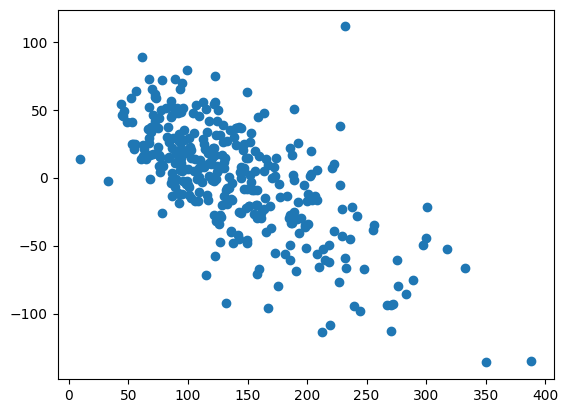

In [13]:
X, y = get_X_y(data_sel, make_dummies=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = XGBRegressor()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
rmse = (((y_pred - y_test) ** 2).mean()) ** 0.5
r2 = (np.corrcoef(y_test, y_pred)[0][1]) ** 2
print(f'RMSE TEST: {round(rmse, 3)}.')
print(f'R2: {round(r2, 3)}.')
plt.scatter(y_test, y_pred - y_test)

### 10.1.2) All columns

/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/arthur/miniconda3/envs/hiwi/lib/python3.11/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:110.23701
[1]	validation_0-rmse:83.38526
[2]	validation_0-rmse:65.86333
[3]	validation_0-rmse:54.82464
[4]	validation_0-rmse:48.29811
[5]	validation_0-rmse:44.94227
[6]	validation_0-rmse:43.31902
[7]	validation_0-rmse:42.77796
[8]	validation_0-rmse:42.26778
[9]	validation_0-rmse:41.95664
[10]	validation_0-rmse:41.73854
[11]	validation_0-rmse:41.80558
[12]	validation_0-rmse:41.73544
[13]	validation_0-rmse:41.84153
[14]	validation_0-rmse:41.99354
[15]	validation_0-rmse:42.07994
[16]	validation_0-rmse:42.23661
[17]	validation_0-rmse:42.19899
[18]	validation_0-rmse:42.11556
[19]	validation_0-rmse:42.11414
[20]	validation_0-rmse:42.10957
[21]	validation_0-rmse:41.96549
[22]	validation_0-rmse:41.89195
RMSE TEST: 41.735.
R2: 0.482.


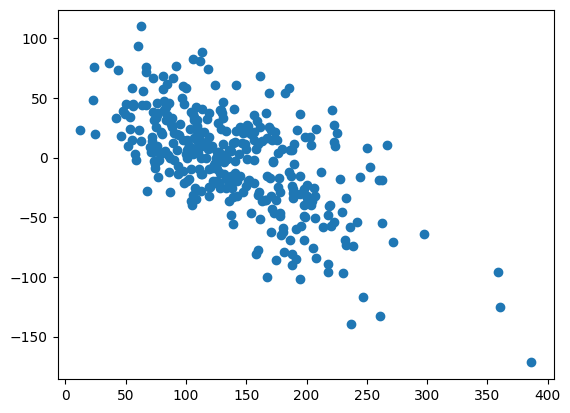

In [14]:
X, y = get_X_y(data_all, make_dummies=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = XGBRegressor()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=eval_set, verbose=True)

y_pred = model.predict(X_test)
rmse = (((y_pred - y_test) ** 2).mean()) ** 0.5
r2 = (np.corrcoef(y_test, y_pred)[0][1]) ** 2
print(f'RMSE TEST: {round(rmse, 3)}.')
print(f'R2: {round(r2, 3)}.')
plt.scatter(y_test, y_pred - y_test)

## 10.2) MLP

In [15]:
X, y = get_X_y(data_sel, make_dummies=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

for hidden_layers in [(8, 8), (16, 16), (32, 32), (8, 8, 8), (16, 16, 16), (32, 32, 32), (8, 8, 8, 8), (8, 8, 8, 8)]:
    for alpha in (1e-3, 1e-5, 1e-7):
        nn = MLPRegressor(solver='lbfgs', alpha=alpha, hidden_layer_sizes=hidden_layers, max_iter=int(1e10), random_state=0)
        nn.fit(X_train, y_train)
        y_pred_train = nn.predict(X_train)
        rmse_train = (((y_pred_train - y_train) ** 2).mean()) ** 0.5
        y_pred_test = nn.predict(X_test)
        rmse_test = (((y_pred_test - y_test) ** 2).mean()) ** 0.5
        r2_test = (np.corrcoef(y_test, y_pred_test)[0][1]) ** 2
        print(f'{hidden_layers} x {alpha}: RMSE TRAIN={round(rmse_train, 3)}, RMSE TEST={round(rmse_test, 3)}, R2 TEST={round(r2_test, 3)}.')

(8, 8) x 0.001: RMSE TRAIN=40.947, RMSE TEST=41.134, R2 TEST=0.541.
(8, 8) x 1e-05: RMSE TRAIN=41.42, RMSE TEST=42.414, R2 TEST=0.51.
(8, 8) x 1e-07: RMSE TRAIN=41.452, RMSE TEST=42.066, R2 TEST=0.519.
(16, 16) x 0.001: RMSE TRAIN=41.373, RMSE TEST=41.651, R2 TEST=0.528.
(16, 16) x 1e-05: RMSE TRAIN=40.431, RMSE TEST=41.131, R2 TEST=0.539.
(16, 16) x 1e-07: RMSE TRAIN=40.093, RMSE TEST=40.944, R2 TEST=0.544.
(32, 32) x 0.001: RMSE TRAIN=39.38, RMSE TEST=41.839, R2 TEST=0.523.
(32, 32) x 1e-05: RMSE TRAIN=38.173, RMSE TEST=42.026, R2 TEST=0.521.
(32, 32) x 1e-07: RMSE TRAIN=38.113, RMSE TEST=41.416, R2 TEST=0.533.
(8, 8, 8) x 0.001: RMSE TRAIN=39.904, RMSE TEST=43.657, R2 TEST=0.482.
(8, 8, 8) x 1e-05: RMSE TRAIN=40.389, RMSE TEST=42.301, R2 TEST=0.512.
(8, 8, 8) x 1e-07: RMSE TRAIN=40.228, RMSE TEST=42.679, R2 TEST=0.504.
(16, 16, 16) x 0.001: RMSE TRAIN=40.983, RMSE TEST=42.969, R2 TEST=0.497.
(16, 16, 16) x 1e-05: RMSE TRAIN=40.465, RMSE TEST=42.097, R2 TEST=0.517.
(16, 16, 16) x 1e-

## 10.3) Gaussian Process Regression

In [16]:
import torch
import gpytorch
torch.set_default_dtype(torch.double)

In [17]:
X, y = get_X_y(data_sel, normalize=True, make_dummies=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = torch.as_tensor(X_train)
y_train = torch.as_tensor(y_train)
X_test = torch.as_tensor(X_test)


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

hyperparams = {
    "covar_module.outputscale": torch.tensor(3.0),
    "covar_module.base_kernel.lengthscale": torch.tensor(1.0),
    "likelihood.noise_covar.noise": torch.tensor(10**-2),
}

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(X_train, y_train, likelihood)
model.initialize(**hyperparams)
model.train()
likelihood.train()
training_iter = 5000
# Choice of optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1)
# (Negative) loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
loss_vals = []
for i in range(training_iter):
    optimizer.zero_grad()
    # Predict on training data
    output = model(X_train)
    # Evaluate loss
    loss = -mll(output, y_train)
    # Compute gradient
    loss.backward()
    loss_vals.append(loss.item())
    if i % 10 == 0:
        print('Iter %d/%d - Loss: %.3f  outputscale: %.3f  lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.outputscale.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    # Update hyperparameters
    optimizer.step()
model.eval()
likelihood.eval()


# Get mean predictions, evaluate
f_pred = model(X_test)
y_pred = likelihood(f_pred)
y_pred_mean = y_pred.mean.detach().numpy()
y_pred_lower, y_pred_upper = y_pred.confidence_region()

Iter 1/5000 - Loss: 3597.072  outputscale: 3.000  lengthscale: 1.000   noise: 0.010
Iter 11/5000 - Loss: 190.165  outputscale: 8.997  lengthscale: 3.794   noise: 4.122
Iter 21/5000 - Loss: 102.314  outputscale: 11.175  lengthscale: 3.992   noise: 9.676
Iter 31/5000 - Loss: 82.483  outputscale: 12.106  lengthscale: 4.253   noise: 12.461
Iter 41/5000 - Loss: 73.799  outputscale: 12.542  lengthscale: 4.514   noise: 14.013
Iter 51/5000 - Loss: 68.770  outputscale: 12.774  lengthscale: 4.752   noise: 15.035
Iter 61/5000 - Loss: 65.231  outputscale: 12.922  lengthscale: 4.965   noise: 15.835
Iter 71/5000 - Loss: 62.409  outputscale: 13.036  lengthscale: 5.157   noise: 16.545
Iter 81/5000 - Loss: 60.002  outputscale: 13.134  lengthscale: 5.333   noise: 17.216
Iter 91/5000 - Loss: 57.862  outputscale: 13.224  lengthscale: 5.495   noise: 17.869
Iter 101/5000 - Loss: 55.930  outputscale: 13.312  lengthscale: 5.647   noise: 18.510
Iter 111/5000 - Loss: 54.180  outputscale: 13.396  lengthscale: 5.

Iter 961/5000 - Loss: 22.014  outputscale: 18.788  lengthscale: 9.814   noise: 53.572
Iter 971/5000 - Loss: 21.911  outputscale: 18.845  lengthscale: 9.828   noise: 53.878
Iter 981/5000 - Loss: 21.810  outputscale: 18.902  lengthscale: 9.842   noise: 54.183
Iter 991/5000 - Loss: 21.710  outputscale: 18.960  lengthscale: 9.855   noise: 54.487
Iter 1001/5000 - Loss: 21.611  outputscale: 19.017  lengthscale: 9.869   noise: 54.790
Iter 1011/5000 - Loss: 21.512  outputscale: 19.074  lengthscale: 9.881   noise: 55.093
Iter 1021/5000 - Loss: 21.419  outputscale: 19.131  lengthscale: 9.894   noise: 55.394
Iter 1031/5000 - Loss: 21.324  outputscale: 19.188  lengthscale: 9.906   noise: 55.694
Iter 1041/5000 - Loss: 21.230  outputscale: 19.245  lengthscale: 9.918   noise: 55.993
Iter 1051/5000 - Loss: 21.139  outputscale: 19.302  lengthscale: 9.930   noise: 56.292
Iter 1061/5000 - Loss: 21.050  outputscale: 19.359  lengthscale: 9.941   noise: 56.589
Iter 1071/5000 - Loss: 20.960  outputscale: 19.

Iter 1901/5000 - Loss: 15.992  outputscale: 24.027  lengthscale: 10.092   noise: 79.535
Iter 1911/5000 - Loss: 15.954  outputscale: 24.082  lengthscale: 10.086   noise: 79.793
Iter 1921/5000 - Loss: 15.912  outputscale: 24.137  lengthscale: 10.081   noise: 80.051
Iter 1931/5000 - Loss: 15.870  outputscale: 24.191  lengthscale: 10.075   noise: 80.309
Iter 1941/5000 - Loss: 15.832  outputscale: 24.246  lengthscale: 10.070   noise: 80.566
Iter 1951/5000 - Loss: 15.791  outputscale: 24.301  lengthscale: 10.064   noise: 80.823
Iter 1961/5000 - Loss: 15.750  outputscale: 24.355  lengthscale: 10.058   noise: 81.080
Iter 1971/5000 - Loss: 15.712  outputscale: 24.410  lengthscale: 10.052   noise: 81.337
Iter 1981/5000 - Loss: 15.672  outputscale: 24.464  lengthscale: 10.046   noise: 81.594
Iter 1991/5000 - Loss: 15.632  outputscale: 24.519  lengthscale: 10.040   noise: 81.850
Iter 2001/5000 - Loss: 15.591  outputscale: 24.573  lengthscale: 10.033   noise: 82.107
Iter 2011/5000 - Loss: 15.556  o

Iter 2841/5000 - Loss: 12.991  outputscale: 29.126  lengthscale: 9.129   noise: 103.321
Iter 2851/5000 - Loss: 12.967  outputscale: 29.180  lengthscale: 9.115   noise: 103.572
Iter 2861/5000 - Loss: 12.943  outputscale: 29.233  lengthscale: 9.101   noise: 103.824
Iter 2871/5000 - Loss: 12.917  outputscale: 29.287  lengthscale: 9.086   noise: 104.076
Iter 2881/5000 - Loss: 12.893  outputscale: 29.341  lengthscale: 9.071   noise: 104.328
Iter 2891/5000 - Loss: 12.871  outputscale: 29.395  lengthscale: 9.056   noise: 104.580
Iter 2901/5000 - Loss: 12.844  outputscale: 29.449  lengthscale: 9.041   noise: 104.832
Iter 2911/5000 - Loss: 12.817  outputscale: 29.503  lengthscale: 9.026   noise: 105.084
Iter 2921/5000 - Loss: 12.798  outputscale: 29.557  lengthscale: 9.011   noise: 105.336
Iter 2931/5000 - Loss: 12.773  outputscale: 29.611  lengthscale: 8.996   noise: 105.588
Iter 2941/5000 - Loss: 12.748  outputscale: 29.665  lengthscale: 8.981   noise: 105.840
Iter 2951/5000 - Loss: 12.725  o

Iter 3781/5000 - Loss: 11.029  outputscale: 34.194  lengthscale: 7.518   noise: 127.354
Iter 3791/5000 - Loss: 11.013  outputscale: 34.248  lengthscale: 7.499   noise: 127.615
Iter 3801/5000 - Loss: 10.996  outputscale: 34.302  lengthscale: 7.481   noise: 127.877
Iter 3811/5000 - Loss: 10.979  outputscale: 34.356  lengthscale: 7.462   noise: 128.139
Iter 3821/5000 - Loss: 10.962  outputscale: 34.410  lengthscale: 7.444   noise: 128.401
Iter 3831/5000 - Loss: 10.944  outputscale: 34.464  lengthscale: 7.425   noise: 128.663
Iter 3841/5000 - Loss: 10.929  outputscale: 34.518  lengthscale: 7.407   noise: 128.926
Iter 3851/5000 - Loss: 10.910  outputscale: 34.573  lengthscale: 7.388   noise: 129.188
Iter 3861/5000 - Loss: 10.893  outputscale: 34.627  lengthscale: 7.370   noise: 129.451
Iter 3871/5000 - Loss: 10.876  outputscale: 34.681  lengthscale: 7.352   noise: 129.714
Iter 3881/5000 - Loss: 10.857  outputscale: 34.735  lengthscale: 7.333   noise: 129.977
Iter 3891/5000 - Loss: 10.843  o

Iter 4721/5000 - Loss: 9.677  outputscale: 39.403  lengthscale: 6.129   noise: 152.796
Iter 4731/5000 - Loss: 9.667  outputscale: 39.461  lengthscale: 6.121   noise: 153.078
Iter 4741/5000 - Loss: 9.655  outputscale: 39.519  lengthscale: 6.114   noise: 153.361
Iter 4751/5000 - Loss: 9.642  outputscale: 39.577  lengthscale: 6.106   noise: 153.643
Iter 4761/5000 - Loss: 9.629  outputscale: 39.635  lengthscale: 6.099   noise: 153.926
Iter 4771/5000 - Loss: 9.616  outputscale: 39.693  lengthscale: 6.092   noise: 154.209
Iter 4781/5000 - Loss: 9.607  outputscale: 39.751  lengthscale: 6.085   noise: 154.492
Iter 4791/5000 - Loss: 9.597  outputscale: 39.810  lengthscale: 6.078   noise: 154.776
Iter 4801/5000 - Loss: 9.584  outputscale: 39.868  lengthscale: 6.072   noise: 155.060
Iter 4811/5000 - Loss: 9.573  outputscale: 39.927  lengthscale: 6.066   noise: 155.344
Iter 4821/5000 - Loss: 9.563  outputscale: 39.985  lengthscale: 6.061   noise: 155.629
Iter 4831/5000 - Loss: 9.552  outputscale: 

40.52063473542862
0.5742216622169772


<ErrorbarContainer object of 3 artists>

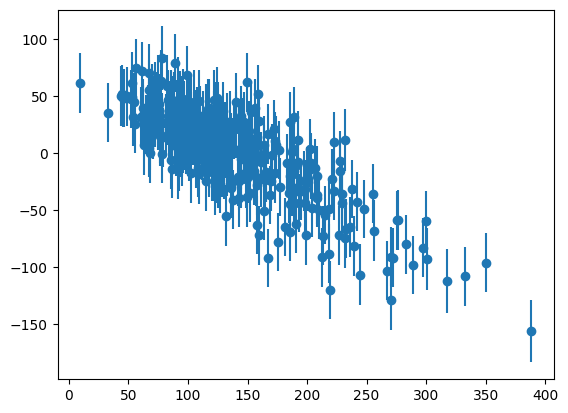

In [18]:
print(((y_pred_mean - y_test) ** 2).mean() ** 0.5)
print((np.corrcoef(y_test, y_pred_mean)[0][1]) ** 2)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_mean - y_test)
ax.errorbar(y_test, y_pred_mean - y_test, yerr=y_pred_upper.detach()-y_pred_mean, linestyle='')